# Citation

Please cite this notebook as follows.

Lagerquist, R., and D.J. Gagne II, 2019: "Interpretation of deep-learning models for predicting thunderstorm rotation: Python tutorial". https://github.com/djgagne/ams-ml-python-course/blob/ryan_branch/module_4/ML_Short_Course_Module_4_Interpretation.ipynb.

The first use of this notebook was for a short course ([Machine Learning in Python for Environmental Science Problems](https://annual.ametsoc.org/index.cfm/2019/programs/short-courses-workshops/machine-learning-in-python-for-environmental-science-problems/)) at the American Meteorological Society's (AMS) 2019 annual meeting.

# Setup

To use this notebook, you will need Python 3.6 and the following packages.

 - scipy
 - TensorFlow
 - Keras
 - scikit-image
 - netCDF4
 - pyproj
 - scikit-learn
 - opencv-python
 - matplotlib
 - shapely
 - geopy
 - metpy
 - descartes

If you have Anaconda on a Linux or Mac, you can install these packages with the following commands.

`pip install scipy`

`pip install tensorflow`

`pip install keras`

`pip install scikit-image`

`pip install netCDF4`

`pip install pyproj`

`pip install scikit-learn`

`pip install opencv-python`

`pip install matplotlib`

`pip install shapely`

`pip install geopy`

`pip install metpy`

`pip install descartes`

# Imports

The next cell imports all libraries that will be used by this notebook.  If the notebook crashes anywhere, it will probably be here.

In [22]:
%matplotlib inline
import copy
import glob
import errno
import pickle
import random
import os.path
import time
import calendar
import numpy
import pandas
import netCDF4
import keras
from sklearn.metrics import auc as scikit_learn_auc
import matplotlib.pyplot as pyplot
from module_4 import keras_metrics
from module_4 import roc_curves
from module_4 import performance_diagrams
from module_4 import attributes_diagrams

# Prevent Auto-scrolling

The next cell prevents output in the notebook from being nested in a scroll box (the scroll box is small and makes things hard to see).

In [23]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Directories

The next cell defines input and output directories.  You will probably want to change these.

In [24]:
DEFAULT_IMAGE_DIR_NAME = (
    '/home/ryan.lagerquist/Downloads/ams2019_short_course/'
    'track_data_ncar_ams_3km_nc_small')
DEFAULT_FEATURE_DIR_NAME = (
    '/home/ryan.lagerquist/Downloads/ams2019_short_course/'
    'track_data_ncar_ams_3km_csv_small')
DEFAULT_OUTPUT_DIR_NAME = '/home/ryan.lagerquist/Downloads/ams2019_short_course'

# Plotting Constants

The next cell defines constants for plotting figures.  I don't recommend changing any of these &ndash; unless the figures are too big on your screen, in which case you should change `FIGURE_WIDTH_INCHES` and `FIGURE_HEIGHT_INCHES`.

In [25]:
FIGURE_WIDTH_INCHES = 15
FIGURE_HEIGHT_INCHES = 15
FIGURE_RESOLUTION_DPI = 300

BAR_GRAPH_FACE_COLOUR = numpy.array([166, 206, 227], dtype=float) / 255
BAR_GRAPH_EDGE_COLOUR = numpy.full(3, 0.)
BAR_GRAPH_EDGE_WIDTH = 2.

FONT_SIZE = 30
pyplot.rc('font', size=FONT_SIZE)
pyplot.rc('axes', titlesize=FONT_SIZE)
pyplot.rc('axes', labelsize=FONT_SIZE)
pyplot.rc('xtick', labelsize=FONT_SIZE)
pyplot.rc('ytick', labelsize=FONT_SIZE)
pyplot.rc('legend', fontsize=FONT_SIZE)
pyplot.rc('figure', titlesize=FONT_SIZE)

# Naming Constants

The next cell defines variable names in the input (CSV and NetCDF) files and keys in dictionaries created by this notebook.  Don't change any of these.

In [29]:
CSV_METADATA_COLUMNS = [
    'Step_ID', 'Track_ID', 'Ensemble_Name', 'Ensemble_Member', 'Run_Date',
    'Valid_Date', 'Forecast_Hour', 'Valid_Hour_UTC'
]

CSV_EXTRANEOUS_COLUMNS = [
    'Duration', 'Centroid_Lon', 'Centroid_Lat', 'Centroid_X', 'Centroid_Y',
    'Storm_Motion_U', 'Storm_Motion_V', 'Matched', 'Max_Hail_Size',
    'Num_Matches', 'Shape', 'Location', 'Scale'
]

CSV_TARGET_NAME = 'RVORT1_MAX-future_max'
TARGET_NAME = 'max_future_vorticity_s01'

NETCDF_REFL_NAME = 'REFL_COM_curr'
NETCDF_TEMP_NAME = 'T2_curr'
NETCDF_U_WIND_NAME = 'U10_curr'
NETCDF_V_WIND_NAME = 'V10_curr'
NETCDF_PREDICTOR_NAMES = [
    NETCDF_REFL_NAME, NETCDF_TEMP_NAME, NETCDF_U_WIND_NAME, NETCDF_V_WIND_NAME
]

REFLECTIVITY_NAME = 'reflectivity_dbz'
TEMPERATURE_NAME = 'temperature_kelvins'
U_WIND_NAME = 'u_wind_m_s01'
V_WIND_NAME = 'v_wind_m_s01'
PREDICTOR_NAMES = [
    REFLECTIVITY_NAME, TEMPERATURE_NAME, U_WIND_NAME, V_WIND_NAME
]

NETCDF_TRACK_ID_NAME = 'track_id'
NETCDF_TRACK_STEP_NAME = 'track_step'
NETCDF_TARGET_NAME = 'RVORT1_MAX_future'

NUM_VALUES_KEY = 'num_values'
MEAN_VALUE_KEY = 'mean_value'
MEAN_OF_SQUARES_KEY = 'mean_of_squares'

STORM_IDS_KEY = 'storm_ids'
STORM_STEPS_KEY = 'storm_steps'
PREDICTOR_NAMES_KEY = 'predictor_names'
PREDICTOR_MATRIX_KEY = 'predictor_matrix'
TARGET_NAME_KEY = 'target_name'
TARGET_MATRIX_KEY = 'target_matrix'

TRAINING_FILES_KEY = 'training_file_names'
NORMALIZATION_DICT_KEY = 'normalization_dict'
BINARIZATION_THRESHOLD_KEY = 'binarization_threshold'
NUM_EXAMPLES_PER_BATCH_KEY = 'num_examples_per_batch'
NUM_TRAINING_BATCHES_KEY = 'num_training_batches_per_epoch'
VALIDATION_FILES_KEY = 'validation_file_names'
NUM_VALIDATION_BATCHES_KEY = 'num_validation_batches_per_epoch'

PERMUTED_PREDICTORS_KEY = 'permuted_predictor_name_by_step'
HIGHEST_COSTS_KEY = 'highest_cost_by_step'
ORIGINAL_COST_KEY = 'original_cost'
STEP1_PREDICTORS_KEY = 'predictor_names_step1'
STEP1_COSTS_KEY = 'costs_step1'

# Deep-learning Constants

The next cell defines constants used by the deep-learning models.  Unless you know what you're doing, don't change any of these.

In [28]:
L1_WEIGHT = 0.
L2_WEIGHT = 0.001
NUM_PREDICTORS_TO_FIRST_NUM_FILTERS = 8
NUM_CONV_LAYER_SETS = 2
NUM_CONV_LAYERS_PER_SET = 2
NUM_CONV_FILTER_ROWS = 3
NUM_CONV_FILTER_COLUMNS = 3
CONV_LAYER_DROPOUT_FRACTION = None
USE_BATCH_NORMALIZATION = True
SLOPE_FOR_RELU = 0.2
NUM_POOLING_ROWS = 2
NUM_POOLING_COLUMNS = 2
NUM_DENSE_LAYERS = 3
DENSE_LAYER_DROPOUT_FRACTION = 0.5

MIN_LOSS_DECR_FOR_EARLY_STOPPING = 0.005
NUM_EPOCHS_FOR_EARLY_STOPPING = 5

LIST_OF_METRIC_FUNCTIONS = [
    keras_metrics.accuracy, keras_metrics.binary_accuracy,
    keras_metrics.binary_csi, keras_metrics.binary_frequency_bias,
    keras_metrics.binary_pod, keras_metrics.binary_pofd,
    keras_metrics.binary_peirce_score, keras_metrics.binary_success_ratio,
    keras_metrics.binary_focn
]

# Miscellaneous Constants

The next cell defines miscellaneous constants.  Don't change any of these.

In [30]:
SEPARATOR_STRING = '\n\n' + '*' * 50 + '\n\n'
MINOR_SEPARATOR_STRING = '\n\n' + '-' * 50 + '\n\n'

DATE_FORMAT = '%Y%m%d'
DATE_FORMAT_REGEX = '[0-9][0-9][0-9][0-9][0-1][0-9][0-3][0-9]'

MIN_PROBABILITY = 1e-15
MAX_PROBABILITY = 1. - MIN_PROBABILITY

# Time Conversion

The next cell defines methods that convert between different time formats.  One converts from a string to Unix time, and the other converts from Unix time to a string.

A string is just a sequence of characters, like "20190106" or "Jan 6 2019".

Unix time is the number of seconds elapsed since 0000 UTC 1 Jan 1970.  Note that both `time_string_to_unix` and `time_unix_to_string` do not handle time zones other than UTC.

In [32]:
def time_string_to_unix(time_string, time_format):
    """Converts time from string to Unix format.

    Unix format = seconds since 0000 UTC 1 Jan 1970.

    :param time_string: Time string.
    :param time_format: Format of time string (example: "%Y%m%d" or
        "%Y-%m-%d-%H%M%S").
    :return: unix_time_sec: Time in Unix format.
    """

    return calendar.timegm(time.strptime(time_string, time_format))


def time_unix_to_string(unix_time_sec, time_format):
    """Converts time from Unix format to string.

    Unix format = seconds since 0000 UTC 1 Jan 1970.

    :param unix_time_sec: Time in Unix format.
    :param time_format: Desired format of time string (example: "%Y%m%d" or
        "%Y-%m-%d-%H%M%S").
    :return: time_string: Time string.
    """

    return time.strftime(time_format, time.gmtime(unix_time_sec))

# Feature Files

The next cell defines methods that locate and read feature (CSV) files.  A "feature file" contains derived features for all storm objects on one day.  A "storm object" is one thunderstorm cell at one time step.  A "derived feature" is a single number (statistic) calculated from the gridded model variables, which include simulated radar reflectivity, temperature, $u$-wind, and $v$-wind.

In [34]:
def _remove_future_data(predictor_table):
    """Removes future data from predictors.

    :param predictor_table: pandas DataFrame with predictor values.  Each row is
        one storm object.
    :return: predictor_table: Same but with fewer columns.
    """

    predictor_names = list(predictor_table)
    columns_to_remove = [p for p in predictor_names if 'future' in p]

    return predictor_table.drop(columns_to_remove, axis=1, inplace=False)


def _feature_file_name_to_date(csv_file_name):
    """Parses date from name of feature (CSV) file.

    :param csv_file_name: Path to input file.
    :return: date_string: Date (format "yyyymmdd").
    """

    pathless_file_name = os.path.split(csv_file_name)[-1]
    date_string = pathless_file_name.replace(
        'track_step_NCARSTORM_d01_', '').replace('-0000.csv', '')

    # Verify.
    time_string_to_unix(time_string=date_string, time_format=DATE_FORMAT)
    return date_string

def find_many_feature_files(first_date_string, last_date_string,
                            feature_dir_name=DEFAULT_FEATURE_DIR_NAME):
    """Finds feature files in the given date range.

    :param first_date_string: First date ("yyyymmdd") in range.
    :param last_date_string: Last date ("yyyymmdd") in range.
    :param feature_dir_name: Name of directory with feature (CSV) files.
    :return: csv_file_names: 1-D list of paths to feature files.
    """

    first_time_unix_sec = time_string_to_unix(
        time_string=first_date_string, time_format=DATE_FORMAT)
    last_time_unix_sec = time_string_to_unix(
        time_string=last_date_string, time_format=DATE_FORMAT)

    csv_file_pattern = '{0:s}/track_step_NCARSTORM_d01_{1:s}-0000.csv'.format(
        feature_dir_name, DATE_FORMAT_REGEX)
    csv_file_names = glob.glob(csv_file_pattern)
    csv_file_names.sort()

    file_date_strings = [_feature_file_name_to_date(f) for f in csv_file_names]
    file_times_unix_sec = numpy.array([
        time_string_to_unix(time_string=d, time_format=DATE_FORMAT)
        for d in file_date_strings
    ], dtype=int)

    good_indices = numpy.where(numpy.logical_and(
        file_times_unix_sec >= first_time_unix_sec,
        file_times_unix_sec <= last_time_unix_sec
    ))[0]

    return [csv_file_names[k] for k in good_indices]


def read_feature_file(csv_file_name):
    """Reads features from CSV file.

    :param csv_file_name: Path to input file.
    :return: metadata_table: pandas DataFrame with metadata.  Each row is one
        storm object.
    :return: predictor_table: pandas DataFrame with predictor values.  Each row
        is one storm object.
    :return: target_table: pandas DataFrame with target values.  Each row is one
        storm object.
    """

    predictor_table = pandas.read_csv(csv_file_name, header=0, sep=',')
    predictor_table.drop(CSV_EXTRANEOUS_COLUMNS, axis=1, inplace=True)

    metadata_table = predictor_table[CSV_METADATA_COLUMNS]
    predictor_table.drop(CSV_METADATA_COLUMNS, axis=1, inplace=True)

    target_table = predictor_table[[CSV_TARGET_NAME]]
    predictor_table.drop([CSV_TARGET_NAME], axis=1, inplace=True)
    predictor_table = _remove_future_data(predictor_table)

    return metadata_table, predictor_table, target_table


def read_many_feature_files(csv_file_names):
    """Reads features from many CSV files.

    :param csv_file_names: 1-D list of paths to input files.
    :return: metadata_table: See doc for `read_feature_file`.
    :return: predictor_table: Same.
    :return: target_table: Same.
    """

    num_files = len(csv_file_names)
    list_of_metadata_tables = [pandas.DataFrame()] * num_files
    list_of_predictor_tables = [pandas.DataFrame()] * num_files
    list_of_target_tables = [pandas.DataFrame()] * num_files

    for i in range(num_files):
        print('Reading data from: "{0:s}"...'.format(csv_file_names[i]))

        (list_of_metadata_tables[i], list_of_predictor_tables[i],
         list_of_target_tables[i]
        ) = read_feature_file(csv_file_names[i])

        if i == 0:
            continue

        list_of_metadata_tables[i] = list_of_metadata_tables[i].align(
            list_of_metadata_tables[0], axis=1
        )[0]

        list_of_predictor_tables[i] = list_of_predictor_tables[i].align(
            list_of_predictor_tables[0], axis=1
        )[0]

        list_of_target_tables[i] = list_of_target_tables[i].align(
            list_of_target_tables[0], axis=1
        )[0]

    metadata_table = pandas.concat(
        list_of_metadata_tables, axis=0, ignore_index=True)
    predictor_table = pandas.concat(
        list_of_predictor_tables, axis=0, ignore_index=True)
    target_table = pandas.concat(
        list_of_target_tables, axis=0, ignore_index=True)

    return metadata_table, predictor_table, target_table

# Feature Files: Example

The next cell finds and reads features for all storm objects in July 2015.

In [36]:
feature_file_names = find_many_feature_files(
    first_date_string='20150701', last_date_string='20150731')
metadata_table, predictor_table, target_table = read_many_feature_files(
    feature_file_names)

print(MINOR_SEPARATOR_STRING)
print('Variables in metadata are as follows:')
for this_column in list(metadata_table):
    print(this_column)

print('\nPredictor variables are as follows:')
for this_column in list(predictor_table):
    print(this_column)

print('\nTarget variables are as follows:')
for this_column in list(target_table):
    print(this_column)

this_predictor_name = list(predictor_table)[0]
these_predictor_values = predictor_table[this_predictor_name].values[:10]
print('\nSome values of predictor variable "{0:s}":\n{1:s}'.format(
    this_predictor_name, str(these_predictor_values)))

this_target_name = list(target_table)[0]
these_target_values = target_table[this_target_name].values[:10]
print('\nSome values of target variable "{0:s}":\n{1:s}'.format(
    this_target_name, str(these_target_values)))

Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20150706-0000.csv"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20150712-0000.csv"...


--------------------------------------------------


Variables in metadata are as follows:
Step_ID
Track_ID
Ensemble_Name
Ensemble_Member
Run_Date
Valid_Date
Forecast_Hour
Valid_Hour_UTC

Predictor variables are as follows:
REFL_COM_mean
REFL_COM_max
REFL_COM_min
REFL_COM_std
REFL_COM_percentile_10
REFL_COM_percentile_25
REFL_COM_percentile_50
REFL_COM_percentile_75
REFL_COM_percentile_90
U10_mean
U10_max
U10_min
U10_std
U10_percentile_10
U10_percentile_25
U10_percentile_50
U10_percentile_75
U10_percentile_90
V10_mean
V10_max
V10_min
V10_std
V10_percentile_10
V10_percentile_25
V10_percentile_50
V10_percentile_75
V10_percentile_90
T2_mean
T2_max
T2_min
T2_std
T2_percentile_10
T2_per

# Image Files

The next cell defines methods that locate and read image (NetCDF) files.  An "image file" contains storm-centered grids of several model variables &ndash; including simulated radar reflectivity (henceforth, just "reflectivity"), temperature, $u$-wind, and $v$-wind &ndash; for all storm objects on one day.  In other words, these files contain raw data as opposed to derived features.

In [37]:
def _image_file_name_to_date(netcdf_file_name):
    """Parses date from name of image (NetCDF) file.

    :param netcdf_file_name: Path to input file.
    :return: date_string: Date (format "yyyymmdd").
    """

    pathless_file_name = os.path.split(netcdf_file_name)[-1]
    date_string = pathless_file_name.replace(
        'NCARSTORM_', '').replace('-0000_d01_model_patches.nc', '')

    # Verify.
    time_string_to_unix(time_string=date_string, time_format=DATE_FORMAT)
    return date_string

def find_many_image_files(first_date_string, last_date_string,
                          image_dir_name=DEFAULT_IMAGE_DIR_NAME):
    """Finds image (NetCDF) files in the given date range.

    :param first_date_string: First date ("yyyymmdd") in range.
    :param last_date_string: Last date ("yyyymmdd") in range.
    :param image_dir_name: Name of directory with image (NetCDF) files.
    :return: netcdf_file_names: 1-D list of paths to image files.
    """

    first_time_unix_sec = time_string_to_unix(
        time_string=first_date_string, time_format=DATE_FORMAT)
    last_time_unix_sec = time_string_to_unix(
        time_string=last_date_string, time_format=DATE_FORMAT)

    netcdf_file_pattern = (
        '{0:s}/NCARSTORM_{1:s}-0000_d01_model_patches.nc'
    ).format(image_dir_name, DATE_FORMAT_REGEX)

    netcdf_file_names = glob.glob(netcdf_file_pattern)
    netcdf_file_names.sort()

    file_date_strings = [_image_file_name_to_date(f) for f in netcdf_file_names]
    file_times_unix_sec = numpy.array([
        time_string_to_unix(time_string=d, time_format=DATE_FORMAT)
        for d in file_date_strings
    ], dtype=int)

    good_indices = numpy.where(numpy.logical_and(
        file_times_unix_sec >= first_time_unix_sec,
        file_times_unix_sec <= last_time_unix_sec
    ))[0]

    return [netcdf_file_names[k] for k in good_indices]


def read_image_file(netcdf_file_name):
    """Reads storm-centered images from NetCDF file.

    E = number of examples (storm objects) in file
    M = number of rows in each storm-centered grid
    N = number of columns in each storm-centered grid
    C = number of channels (predictor variables)

    :param netcdf_file_name: Path to input file.
    :return: image_dict: Dictionary with the following keys.
    image_dict['storm_ids']: length-E list of storm IDs (integers).
    image_dict['storm_steps']: length-E numpy array of storm steps (integers).
    image_dict['predictor_names']: length-C list of predictor names.
    image_dict['predictor_matrix']: E-by-M-by-N-by-C numpy array of predictor
        values.
    image_dict['target_name']: Name of target variable.
    image_dict['target_matrix']: E-by-M-by-N numpy array of target values.
    """

    dataset_object = netCDF4.Dataset(netcdf_file_name)

    storm_ids = numpy.array(
        dataset_object.variables[NETCDF_TRACK_ID_NAME][:], dtype=int)
    storm_steps = numpy.array(
        dataset_object.variables[NETCDF_TRACK_STEP_NAME][:], dtype=int)

    predictor_matrix = None

    for this_predictor_name in NETCDF_PREDICTOR_NAMES:
        this_predictor_matrix = numpy.array(
            dataset_object.variables[this_predictor_name][:], dtype=float)
        this_predictor_matrix = numpy.expand_dims(
            this_predictor_matrix, axis=-1)

        if predictor_matrix is None:
            predictor_matrix = this_predictor_matrix + 0.
        else:
            predictor_matrix = numpy.concatenate(
                (predictor_matrix, this_predictor_matrix), axis=-1)

    target_matrix = numpy.array(
        dataset_object.variables[NETCDF_TARGET_NAME][:], dtype=float)

    return {
        STORM_IDS_KEY: storm_ids,
        STORM_STEPS_KEY: storm_steps,
        PREDICTOR_NAMES_KEY: PREDICTOR_NAMES,
        PREDICTOR_MATRIX_KEY: predictor_matrix,
        TARGET_NAME_KEY: TARGET_NAME,
        TARGET_MATRIX_KEY: target_matrix
    }


def read_many_image_files(netcdf_file_names):
    """Reads storm-centered images from many NetCDF files.

    :param netcdf_file_names: 1-D list of paths to input files.
    :return: image_dict: See doc for `read_image_file`.
    """

    image_dict = None
    keys_to_concat = [
        STORM_IDS_KEY, STORM_STEPS_KEY, PREDICTOR_MATRIX_KEY, TARGET_MATRIX_KEY
    ]

    for this_file_name in netcdf_file_names:
        print('Reading data from: "{0:s}"...'.format(this_file_name))
        this_image_dict = read_image_file(this_file_name)

        if image_dict is None:
            image_dict = copy.deepcopy(this_image_dict)
            continue

        for this_key in keys_to_concat:
            image_dict[this_key] = numpy.concatenate(
                (image_dict[this_key], this_image_dict[this_key]), axis=0)

    return image_dict

# Image Files: Example 1

The next cell finds and reads images for all storm objects in July 2015.

In [38]:
image_file_names = find_many_image_files(
    first_date_string='20150701', last_date_string='20150731')
image_dict = read_many_image_files(image_file_names)

print(MINOR_SEPARATOR_STRING)
print('Variables in dictionary are as follows:')
for this_key in image_dict.keys():
    print(this_key)

print('\nPredictor variables are as follows:')
predictor_names = image_dict[PREDICTOR_NAMES_KEY]
for this_name in predictor_names:
    print(this_name)

these_predictor_values = image_dict[PREDICTOR_MATRIX_KEY][0, :5, :5, 0]
print((
    '\nSome values of predictor variable "{0:s}" for first storm object:'
    '\n{1:s}'
).format(predictor_names[0], str(these_predictor_values)))

these_target_values = image_dict[TARGET_MATRIX_KEY][0, :5, :5]
print((
    '\nSome values of target variable "{0:s}" for first storm object:'
    '\n{1:s}'
).format(image_dict[TARGET_NAME_KEY], str(these_target_values)))

Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150706-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150712-0000_d01_model_patches.nc"...


--------------------------------------------------


Variables in dictionary are as follows:
storm_ids
storm_steps
predictor_names
predictor_matrix
target_name
target_matrix

Predictor variables are as follows:
reflectivity_dbz
temperature_kelvins
u_wind_m_s01
v_wind_m_s01

Some values of predictor variable "reflectivity_dbz" for first storm object:
[[13.97686386 19.82977104 19.72230339 12.15658951 24.21878624]
 [11.72174263 16.28964233 17.1885643   8.1463623  21.16093636]
 [ 8.37331963 13.1016016  13.51956081  4.92564344 15.90840054]
 [ 1.74170113 11.59834766  7.84896898  0.69869119  4.64704037]
 [ 6.33569193  7.28762817  7.5872879   8.06334972 10.47385979]]

Some values of targ

# Training Files

The next cell finds and reads training files (images from 2010-2014) for deep learning.

In [41]:
training_file_names = find_many_image_files(
    first_date_string='20100101', last_date_string='20141231')

# Normalization Parameters

The next cell defines methods that find the normalization parameters (mean and standard deviation of each model variable) over a large number of files.  The means and standard deviations are updated iteratively (whenever a new file is read), which obviates the need to load all files into memory at once.  This would take up several GB of memory and potentially crash the notebook.

In [42]:
def _update_normalization_params(intermediate_normalization_dict, new_values):
    """Updates normalization params for one predictor.

    :param intermediate_normalization_dict: Dictionary with the following keys.
    intermediate_normalization_dict['num_values']: Number of values on which
        current estimates are based.
    intermediate_normalization_dict['mean_value']: Current estimate for mean.
    intermediate_normalization_dict['mean_of_squares']: Current mean of squared
        values.

    :param new_values: numpy array of new values (will be used to update
        `intermediate_normalization_dict`).
    :return: intermediate_normalization_dict: Same as input but with updated
        values.
    """

    if MEAN_VALUE_KEY not in intermediate_normalization_dict:
        intermediate_normalization_dict = {
            NUM_VALUES_KEY: 0,
            MEAN_VALUE_KEY: 0.,
            MEAN_OF_SQUARES_KEY: 0.
        }

    these_means = numpy.array([
        intermediate_normalization_dict[MEAN_VALUE_KEY], numpy.mean(new_values)
    ])
    these_weights = numpy.array([
        intermediate_normalization_dict[NUM_VALUES_KEY], new_values.size
    ])

    intermediate_normalization_dict[MEAN_VALUE_KEY] = numpy.average(
        these_means, weights=these_weights)

    these_means = numpy.array([
        intermediate_normalization_dict[MEAN_OF_SQUARES_KEY],
        numpy.mean(new_values ** 2)
    ])

    intermediate_normalization_dict[MEAN_OF_SQUARES_KEY] = numpy.average(
        these_means, weights=these_weights)

    intermediate_normalization_dict[NUM_VALUES_KEY] += new_values.size
    return intermediate_normalization_dict


def _get_standard_deviation(intermediate_normalization_dict):
    """Computes stdev from intermediate normalization params.

    :param intermediate_normalization_dict: See doc for
        `_update_normalization_params`.
    :return: standard_deviation: Standard deviation.
    """

    num_values = float(intermediate_normalization_dict[NUM_VALUES_KEY])
    multiplier = num_values / (num_values - 1)

    return numpy.sqrt(multiplier * (
        intermediate_normalization_dict[MEAN_OF_SQUARES_KEY] -
        intermediate_normalization_dict[MEAN_VALUE_KEY] ** 2
    ))


def get_image_normalization_params(netcdf_file_names):
    """Computes normalization params (mean and stdev) for each predictor.

    :param netcdf_file_names: 1-D list of paths to input files.
    :return: normalization_dict: See input doc for `normalize_images`.
    """

    predictor_names = None
    norm_dict_by_predictor = None

    for this_file_name in netcdf_file_names:
        print('Reading data from: "{0:s}"...'.format(this_file_name))
        this_image_dict = read_image_file(this_file_name)

        if predictor_names is None:
            predictor_names = this_image_dict[PREDICTOR_NAMES_KEY]
            norm_dict_by_predictor = [{}] * len(predictor_names)

        for m in range(len(predictor_names)):
            norm_dict_by_predictor[m] = _update_normalization_params(
                intermediate_normalization_dict=norm_dict_by_predictor[m],
                new_values=this_image_dict[PREDICTOR_MATRIX_KEY][..., m])

    print('\n')
    normalization_dict = {}

    for m in range(len(predictor_names)):
        this_mean = norm_dict_by_predictor[m][MEAN_VALUE_KEY]
        this_stdev = _get_standard_deviation(norm_dict_by_predictor[m])
        normalization_dict[predictor_names[m]] = numpy.array(
            [this_mean, this_stdev])

        print((
            'Mean and standard deviation for "{0:s}" = {1:.4f}, {2:.4f}'
        ).format(predictor_names[m], this_mean, this_stdev))

    return normalization_dict

# Normalization Parameters: Example

The next cell computes the normalization parameters that will be used throughout this notebook.  Normalization parameters should be computed only on the training data, and the same parameters should be used to normalize any other data (*e.g.*, validation data, testing data, or future data in an operational forecasting application).

In [43]:
normalization_dict = get_image_normalization_params(training_file_names)

Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20101024-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20101122-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110201-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110308-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110326-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110404-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_cour

Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140508-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140514-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140526-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140604-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140609-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140617-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_cour

# Normalization and Denormalization

The next cell defines methods that normalize and denormalize images.

In [44]:
def normalize_images(
        predictor_matrix, predictor_names, normalization_dict=None):
    """Normalizes images to z-scores.

    E = number of examples (storm objects) in file
    M = number of rows in each storm-centered grid
    N = number of columns in each storm-centered grid
    C = number of channels (predictor variables)

    :param predictor_matrix: E-by-M-by-N-by-C numpy array of predictor values.
    :param predictor_names: length-C list of predictor names.
    :param normalization_dict: Dictionary.  Each key is the name of a predictor
        value, and the corresponding value is a length-2 numpy array with
        [mean, standard deviation].  If `normalization_dict is None`, mean and
        standard deviation will be computed for each predictor.
    :return: predictor_matrix: Normalized version of input.
    :return: normalization_dict: See doc for input variable.  If input was None,
        this will be a newly created dictionary.  Otherwise, this will be the
        same dictionary passed as input.
    """

    num_predictors = len(predictor_names)

    if normalization_dict is None:
        normalization_dict = {}

        for m in range(num_predictors):
            this_mean = numpy.mean(predictor_matrix[..., m])
            this_stdev = numpy.std(predictor_matrix[..., m], ddof=1)

            normalization_dict[predictor_names[m]] = numpy.array(
                [this_mean, this_stdev])

    for m in range(num_predictors):
        this_mean = normalization_dict[predictor_names[m]][0]
        this_stdev = normalization_dict[predictor_names[m]][1]

        predictor_matrix[..., m] = (
            (predictor_matrix[..., m] - this_mean) / this_stdev
        )

    return predictor_matrix, normalization_dict


def denormalize_images(predictor_matrix, predictor_names, normalization_dict):
    """Denormalizes images from z-scores back to original scales.

    :param predictor_matrix: See doc for `normalize_images`.
    :param predictor_names: Same.
    :param normalization_dict: Same.
    :return: predictor_matrix: Denormalized version of input.
    """

    num_predictors = len(predictor_names)
    for m in range(num_predictors):
        this_mean = normalization_dict[predictor_names[m]][0]
        this_stdev = normalization_dict[predictor_names[m]][1]

        predictor_matrix[..., m] = (
            this_mean + this_stdev * predictor_matrix[..., m]
        )

    return predictor_matrix

# Normalization and Denormalization: Example

The next cell normalizes and denormalizes images from one file.  The denormalized values should be exactly equal to the original values.

In [45]:
image_dict = read_image_file(training_file_names[0])

predictor_names = image_dict[PREDICTOR_NAMES_KEY]
these_predictor_values = image_dict[PREDICTOR_MATRIX_KEY][0, :5, :5, 0]

print((
    '\nOriginal values of "{0:s}" for first storm object:\n{1:s}'
).format(predictor_names[0], str(these_predictor_values)))

image_dict[PREDICTOR_MATRIX_KEY], _ = normalize_images(
    predictor_matrix=image_dict[PREDICTOR_MATRIX_KEY],
    predictor_names=predictor_names, normalization_dict=normalization_dict)

these_predictor_values = image_dict[PREDICTOR_MATRIX_KEY][0, :5, :5, 0]
print((
    '\nNormalized values of "{0:s}" for first storm object:\n{1:s}'
).format(predictor_names[0], str(these_predictor_values)))

image_dict[PREDICTOR_MATRIX_KEY] = denormalize_images(
    predictor_matrix=image_dict[PREDICTOR_MATRIX_KEY],
    predictor_names=predictor_names, normalization_dict=normalization_dict)

these_predictor_values = image_dict[PREDICTOR_MATRIX_KEY][0, :5, :5, 0]
print((
    '\nDenormalized values of "{0:s}" for first storm object:\n{1:s}'
).format(predictor_names[0], str(these_predictor_values)))


Original values of "reflectivity_dbz" for first storm object:
[[ 0.          6.9651885   6.99899673  3.64286256  0.        ]
 [ 1.818367    4.22854471  0.28074482  0.          0.        ]
 [ 7.24424314  4.46407127  0.          0.          0.        ]
 [16.65088844 18.46622086 17.29220772 13.19463634  2.80103612]
 [19.96715736 22.98410988 23.0850563  19.88584709 11.70358849]]

Normalized values of "reflectivity_dbz" for first storm object:
[[-1.43928327 -0.99737685 -0.99523189 -1.20816184 -1.43928327]
 [-1.32391697 -1.17100323 -1.42147142 -1.43928327 -1.43928327]
 [-0.97967223 -1.15606025 -1.43928327 -1.43928327 -1.43928327]
 [-0.38286757 -0.2676938  -0.34217907 -0.6021495  -1.26157152]
 [-0.17246687  0.0189437   0.02534824 -0.1776256  -0.69674904]]

Denormalized values of "reflectivity_dbz" for first storm object:
[[ 0.          6.9651885   6.99899673  3.64286256  0.        ]
 [ 1.818367    4.22854471  0.28074482  0.          0.        ]
 [ 7.24424314  4.46407127  0.          0.      

# Binarization Threshold

The next cell defines a method that finds the "binarization threshold," used to simplify the target variable (maximum future vorticity within the same storm).  The original target variable is a $32 \times 32$ image, where the value at grid cell $(i, j)$ is the max future vorticity within the storm at grid cell $(i, j)$.  One could train a deep-learning model to predict max future vorticity at each grid cell, but this would be a regression task with 1024 output variables, which would make the rest of this notebook too complicated for a 1.5-hour tutorial.

To simplify the prediction task, the binarization threshold ($\zeta^*$) is applied to the max future vorticity over all 1024 grid cells.  If this value is $\ge \zeta^*$, the storm object is labeled a "1" or "yes"; otherwise, the storm object is labeled a "0" or "no".  This turns the prediction task into binary classification with only one output variable.

In [46]:
def get_binarization_threshold(netcdf_file_names, percentile_level):
    """Computes binarization threshold for target variable.

    Binarization threshold will be [q]th percentile of all image maxima, where
    q = `percentile_level`.

    :param netcdf_file_names: 1-D list of paths to input files.
    :param percentile_level: q in the above discussion.
    :return: binarization_threshold: Binarization threshold (used to turn each
        target image into a yes-or-no label).
    """

    max_target_values = numpy.array([])

    for this_file_name in netcdf_file_names:
        print('Reading data from: "{0:s}"...'.format(this_file_name))
        this_image_dict = read_image_file(this_file_name)

        this_target_matrix = this_image_dict[TARGET_MATRIX_KEY]
        this_num_examples = this_target_matrix.shape[0]
        these_max_target_values = numpy.full(this_num_examples, numpy.nan)

        for i in range(this_num_examples):
            these_max_target_values[i] = numpy.max(this_target_matrix[i, ...])

        max_target_values = numpy.concatenate((
            max_target_values, these_max_target_values))

    binarization_threshold = numpy.percentile(
        max_target_values, percentile_level)

    print('\nBinarization threshold for "{0:s}" = {1:.4e}'.format(
        TARGET_NAME, binarization_threshold))

    return binarization_threshold

# Binarization Threshold: Example

The next cell computes the binarizarion threshold that will be used throughout this notebook.  The binarization threshold should be computed only on the training data, and the same threshold should be used to binarize any other data (*e.g.*, validation data, testing data, or future data in an operational forecasting application).

In [47]:
binarization_threshold = get_binarization_threshold(
    netcdf_file_names=training_file_names, percentile_level=90.)

Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20101024-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20101122-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110201-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110308-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110326-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110404-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_cour

Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140514-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140526-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140604-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140609-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140617-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140622-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_cour

# Binarization

The next cell defines the method that actually binarizes images of the target variable.

In [48]:
def binarize_target_images(target_matrix, binarization_threshold):
    """Binarizes target images.

    Specifically, this method turns each target image into a binary label,
    depending on whether or not (max value in image) >= binarization_threshold.

    E = number of examples (storm objects) in file
    M = number of rows in each storm-centered grid
    N = number of columns in each storm-centered grid

    :param target_matrix: E-by-M-by-N numpy array of floats.
    :param binarization_threshold: Binarization threshold.
    :return: target_values: length-E numpy array of target values (integers in
        0...1).
    """

    num_examples = target_matrix.shape[0]
    target_values = numpy.full(num_examples, -1, dtype=int)

    for i in range(num_examples):
        target_values[i] = (
            numpy.max(target_matrix[i, ...]) >= binarization_threshold
        )

    return target_values

# Binarization: Example

The next cell binarizes images from one file.

In [51]:
image_dict = read_image_file(training_file_names[0])
these_max_target_values = numpy.array(
    [numpy.max(image_dict[TARGET_MATRIX_KEY][i, ...]) for i in range(10)]
)

print((
    '\nSpatial maxima of "{0:s}" for the first few storm objects:\n{1:s}'
).format(image_dict[TARGET_NAME_KEY], str(these_max_target_values)))

target_values = binarize_target_images(
    target_matrix=image_dict[TARGET_MATRIX_KEY],
    binarization_threshold=binarization_threshold)

print(('\nBinarized target values for the first few storm objects:\n{0:s}'
).format(str(target_values[:10])))


Spatial maxima of "max_future_vorticity_s01" for the first few storm objects:
[0.0021904  0.00241288 0.00241288 0.00245462 0.00258843 0.00216414
 0.001725   0.00137892 0.00147138 0.00117736 0.00110742 0.00126975
 0.00140948 0.00181028 0.00101287 0.00114279 0.00090664 0.00183228
 0.00217285 0.00144518 0.00142109 0.00137595 0.00217285 0.00148447
 0.00142109 0.00125107 0.00217285 0.00126712 0.00215662 0.00210133
 0.00220041 0.00191494 0.00182135 0.00147781 0.00114157 0.00205545
 0.00181848 0.0016546  0.0017354  0.00235808 0.00264991 0.00261148
 0.00237809 0.00186979 0.00147039 0.00139423 0.00180136 0.00226576
 0.00189951 0.00181783 0.00210816 0.00210816 0.00264885 0.00338676
 0.00239803 0.00141237 0.00225442 0.00176171 0.00240427 0.0020201
 0.00265859 0.00319321 0.00184279 0.00163179 0.00180779 0.00225442
 0.00126762 0.00161    0.00236216 0.00222683 0.00177118 0.00265859
 0.00268675 0.00295149 0.00221235 0.00190601 0.00121637 0.00173994
 0.00124561 0.00246675 0.0025661  0.00177925 0.0018

Set up CNN (convolutional neural network).  "Setting up" means specifying the architecture, loss function, and optimizer.

In [18]:
this_image_dict = read_image_file(training_file_names[0])
model_object = setup_cnn(
    num_grid_rows=this_image_dict[PREDICTOR_MATRIX_KEY].shape[1],
    num_grid_columns=this_image_dict[PREDICTOR_MATRIX_KEY].shape[2])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 30, 32)        1184      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 28, 28, 64)        0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 28, 28, 64)        256       
__________

Find validation files for deep learning.  These will be used to monitor CNN performance on the fly (during training) and to evaluate the CNN after training.

In [19]:
validation_file_names = find_many_image_files(
    image_dir_name=input_image_dir_name,
    first_date_string='20150101', last_date_string='20151231')

Train the CNN.

In [20]:
cnn_file_name = '{0:s}/cnn_model.h5'.format(output_dir_name)
model_metadata_dict = train_cnn(
    model_object=model_object, training_file_names=training_file_names,
    normalization_dict=normalization_dict,
    binarization_threshold=binarization_threshold,
    num_examples_per_batch=100, num_epochs=10,
    num_training_batches_per_epoch=10,
    validation_file_names=validation_file_names,
    num_validation_batches_per_epoch=10,
    output_model_file_name=cnn_file_name)
print(SEPARATOR_STRING)

Epoch 1/10
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20120701-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.1300
 1/10 [==>...........................] - ETA: 20s - loss: 1.9403 - accuracy: 0.0486 - binary_accuracy: 0.4705 - binary_csi: 0.0840 - binary_frequency_bias: 3.8204 - binary_pod: 0.3737 - binary_pofd: 0.5150 - binary_peirce_score: -0.1413 - binary_success_ratio: 0.0978 - binary_focn: 0.8382Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20130708-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.0400
 2/10 [=====>........................] - ETA: 12s - loss: 1.9379 - accuracy: 0.0368 - binary_accuracy: 0.5047 - binary_csi: 0.0678 - binary_frequency_bias: 7.8005 - binary_pod: 0.5003 - binary_pofd: 0.4899 - binary_peirce_score: 0.0104 - binary_success_ratio: 0.0755 - binary_focn: 0.9050 Reading

 2/10 [=====>........................] - ETA: 4s - loss: 1.7336 - accuracy: 0.0568 - binary_accuracy: 0.5529 - binary_csi: 0.1128 - binary_frequency_bias: 5.7846 - binary_pod: 0.6638 - binary_pofd: 0.4577 - binary_peirce_score: 0.2061 - binary_success_ratio: 0.1196 - binary_focn: 0.9463Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20130602-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.0600
 3/10 [========>.....................] - ETA: 4s - loss: 1.7209 - accuracy: 0.0526 - binary_accuracy: 0.5533 - binary_csi: 0.1052 - binary_frequency_bias: 6.4907 - binary_pod: 0.6876 - binary_pofd: 0.4576 - binary_peirce_score: 0.2300 - binary_success_ratio: 0.1108 - binary_focn: 0.9541Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110712-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.0400
 4/10 [===========>...

Fraction of examples in positive class: 0.0700
 4/10 [===========>..................] - ETA: 3s - loss: 1.6414 - accuracy: 0.0582 - binary_accuracy: 0.5666 - binary_csi: 0.1177 - binary_frequency_bias: 5.7483 - binary_pod: 0.6804 - binary_pofd: 0.4429 - binary_peirce_score: 0.2376 - binary_success_ratio: 0.1258 - binary_focn: 0.9454Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140425-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.1100
 5/10 [==============>...............] - ETA: 3s - loss: 1.6252 - accuracy: 0.0618 - binary_accuracy: 0.5701 - binary_csi: 0.1252 - binary_frequency_bias: 5.4323 - binary_pod: 0.6833 - binary_pofd: 0.4402 - binary_peirce_score: 0.2431 - binary_success_ratio: 0.1340 - binary_focn: 0.9439Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110425-0000_d01_model_patches.nc"...
Fraction of examples i

 6/10 [=================>............] - ETA: 2s - loss: 1.5518 - accuracy: 0.0698 - binary_accuracy: 0.5865 - binary_csi: 0.1434 - binary_frequency_bias: 4.8902 - binary_pod: 0.6751 - binary_pofd: 0.4223 - binary_peirce_score: 0.2529 - binary_success_ratio: 0.1559 - binary_focn: 0.9362Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110404-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.1900
 7/10 [====================>.........] - ETA: 1s - loss: 1.5393 - accuracy: 0.0766 - binary_accuracy: 0.5890 - binary_csi: 0.1556 - binary_frequency_bias: 4.5231 - binary_pod: 0.6669 - binary_pofd: 0.4190 - binary_peirce_score: 0.2479 - binary_success_ratio: 0.1716 - binary_focn: 0.9267Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110620-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.1000
 8/10 [===============

Fraction of examples in positive class: 0.1200
 8/10 [=======================>......] - ETA: 1s - loss: 1.5019 - accuracy: 0.0677 - binary_accuracy: 0.5924 - binary_csi: 0.1391 - binary_frequency_bias: 5.1699 - binary_pod: 0.6490 - binary_pofd: 0.4105 - binary_peirce_score: 0.2385 - binary_success_ratio: 0.1560 - binary_focn: 0.9273Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20120426-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.0800
 9/10 [==========================>...] - ETA: 0s - loss: 1.5055 - accuracy: 0.0647 - binary_accuracy: 0.5896 - binary_csi: 0.1332 - binary_frequency_bias: 5.1981 - binary_pod: 0.6334 - binary_pofd: 0.4124 - binary_peirce_score: 0.2210 - binary_success_ratio: 0.1491 - binary_focn: 0.9276Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110201-0000_d01_model_patches.nc"...
Fraction of examples i

Fraction of examples in positive class: 0.1800
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20151227-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.1000
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150528-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.0900
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150706-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.0400
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150612-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.1100
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150630-0000_d01_model_patch

Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150625-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.0800
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150523-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.1200
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20151227-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.1400
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150528-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.0700
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150706-0000_d01_model_patches.nc"...
Fraction of examples in positive clas

Fraction of examples in positive class: 0.0800
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150331-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.0000
10/10 [==============================] - 10s 1s/step - loss: 1.2470 - accuracy: 0.0795 - binary_accuracy: 0.6347 - binary_csi: 0.1715 - binary_frequency_bias: 8.1740 - binary_pod: 0.6592 - binary_pofd: 0.3631 - binary_peirce_score: 0.2961 - binary_success_ratio: 0.1989 - binary_focn: 0.9225 - val_loss: 1.0612 - val_accuracy: 0.0562 - val_binary_accuracy: 0.6909 - val_binary_csi: 0.1420 - val_binary_frequency_bias: 26130527.0043 - val_binary_pod: 0.5493 - val_binary_pofd: 0.3034 - val_binary_peirce_score: 0.2460 - val_binary_success_ratio: 0.1598 - val_binary_focn: 0.9481

Epoch 00008: val_loss improved from 1.24133 to 1.06115, saving model to /home/ryan.lagerquist/Downloads/ams2019_short_course/cnn_model.h5
Epoch 9/10
Reading data from: "/ho


Epoch 00009: val_loss improved from 1.06115 to 1.05606, saving model to /home/ryan.lagerquist/Downloads/ams2019_short_course/cnn_model.h5
Epoch 10/10
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20120706-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.1000
 1/10 [==>...........................] - ETA: 5s - loss: 1.2099 - accuracy: 0.0500 - binary_accuracy: 0.6031 - binary_csi: 0.1119 - binary_frequency_bias: 3.9693 - binary_pod: 0.5002 - binary_pofd: 0.3855 - binary_peirce_score: 0.1147 - binary_success_ratio: 0.1260 - binary_focn: 0.9171Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110605-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.1100
 2/10 [=====>........................] - ETA: 4s - loss: 1.1547 - accuracy: 0.0579 - binary_accuracy: 0.6204 - binary_csi: 0.1328 - binary_frequency_bias: 3.7

Evaluate the CNN on validation data.

Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150625-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150523-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20151227-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150528-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150706-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150612-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_cour

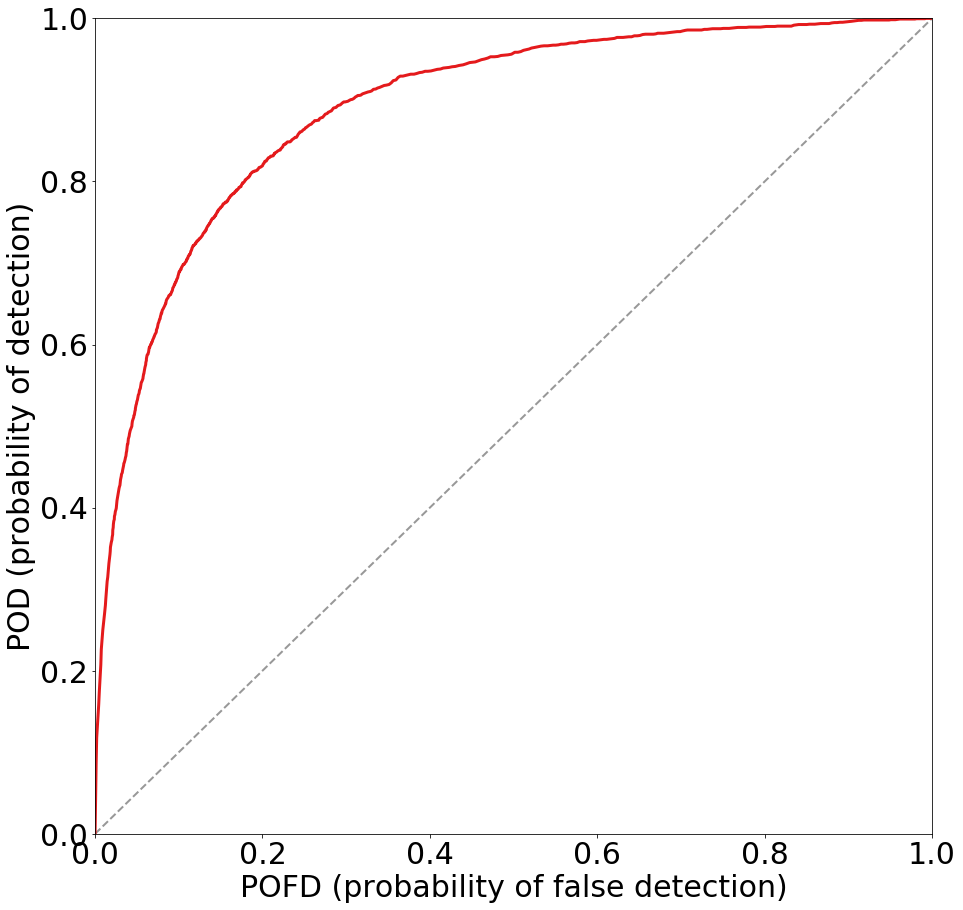

Area under ROC curve: 0.8909
Saving figure to: "/home/ryan.lagerquist/Downloads/ams2019_short_course/validation/roc_curve.jpg"...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ams_ml_python_course-0.1-py3.6.egg/module_4/performance_diagrams.py:226: RuntimeWarning: invalid value encountered in true_divide
  float(this_num_hits) / (this_num_hits + this_num_false_alarms)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ams_ml_python_course-0.1-py3.6.egg/module_4/performance_diagrams.py:65: RuntimeWarning: divide by zero encountered in reciprocal
  return (success_ratio_array ** -1 + pod_array ** -1 - 1.) ** -1
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ams_ml_python_course-0.1-py3.6.egg/module_4/performance_diagrams.py:78: RuntimeWarning: divide by zero encountered in true_divide
  return pod_array / success_ratio_array
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ams_ml_python_course-0.1-py3.6.egg/module_4/performance_diagrams.py:78: RuntimeWarning: invalid value encountered in true_divide
  return pod_array

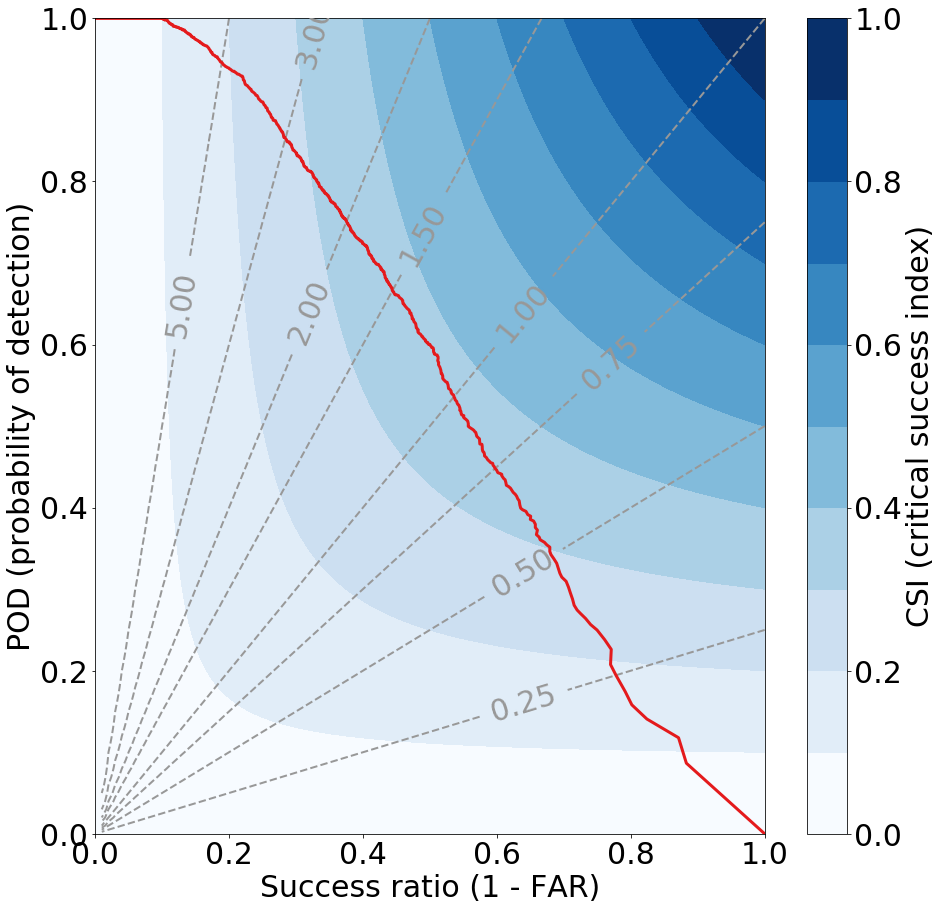

Saving figure to: "/home/ryan.lagerquist/Downloads/ams2019_short_course/validation/performance_diagram.jpg"...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


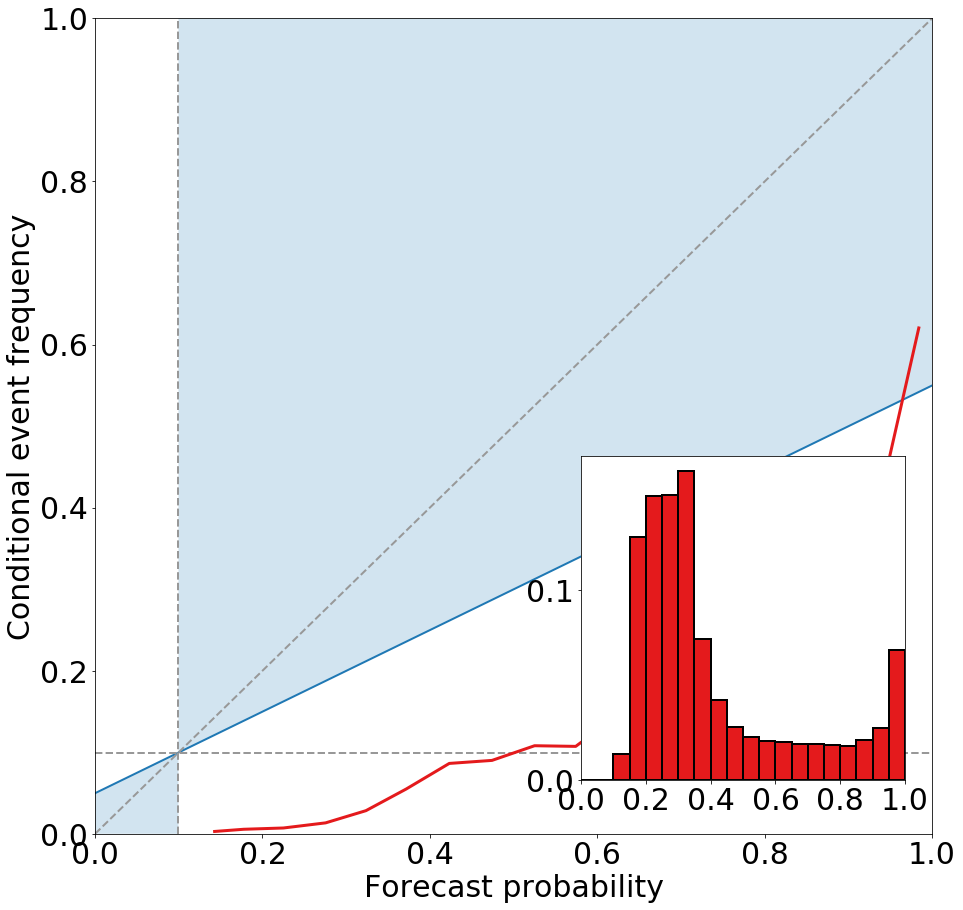

Saving figure to: "/home/ryan.lagerquist/Downloads/ams2019_short_course/validation/attributes_diagram.jpg"...


**************************************************




In [21]:
validation_image_dict = read_many_image_files(validation_file_names)
print(SEPARATOR_STRING)

validation_dir_name = '{0:s}/validation'.format(output_dir_name)
evaluate_cnn(
    model_object=model_object, image_dict=validation_image_dict,
    model_metadata_dict=model_metadata_dict,
    output_dir_name=validation_dir_name)
print(SEPARATOR_STRING)

Run permutation test on validation data.

In [22]:
permutation_dir_name = '{0:s}/permutation_test'.format(output_dir_name)
main_permutation_file_name = '{0:s}/permutation_results.p'.format(
    permutation_dir_name)

permutation_dict = permutation_test_for_cnn(
    model_object=model_object, image_dict=validation_image_dict,
    model_metadata_dict=model_metadata_dict,
    output_pickle_file_name=main_permutation_file_name)
print(SEPARATOR_STRING)

Applying model to examples 0-999 of 25392...
Applying model to examples 1000-1999 of 25392...
Applying model to examples 2000-2999 of 25392...
Applying model to examples 3000-3999 of 25392...
Applying model to examples 4000-4999 of 25392...
Applying model to examples 5000-5999 of 25392...
Applying model to examples 6000-6999 of 25392...
Applying model to examples 7000-7999 of 25392...
Applying model to examples 8000-8999 of 25392...
Applying model to examples 9000-9999 of 25392...
Applying model to examples 10000-10999 of 25392...
Applying model to examples 11000-11999 of 25392...
Applying model to examples 12000-12999 of 25392...
Applying model to examples 13000-13999 of 25392...
Applying model to examples 14000-14999 of 25392...
Applying model to examples 15000-15999 of 25392...
Applying model to examples 16000-16999 of 25392...
Applying model to examples 17000-17999 of 25392...
Applying model to examples 18000-18999 of 25392...
Applying model to examples 19000-19999 of 25392...
Appl

Applying model to examples 12000-12999 of 25392...
Applying model to examples 13000-13999 of 25392...
Applying model to examples 14000-14999 of 25392...
Applying model to examples 15000-15999 of 25392...
Applying model to examples 16000-16999 of 25392...
Applying model to examples 17000-17999 of 25392...
Applying model to examples 18000-18999 of 25392...
Applying model to examples 19000-19999 of 25392...
Applying model to examples 20000-20999 of 25392...
Applying model to examples 21000-21999 of 25392...
Applying model to examples 22000-22999 of 25392...
Applying model to examples 23000-23999 of 25392...
Applying model to examples 24000-24999 of 25392...
Applying model to examples 25000-25391 of 25392...


--------------------------------------------------


Resulting cost = 8.9798e-01
Trying predictor "temperature_kelvins" at step 2 of permutation test...


--------------------------------------------------


Applying model to examples 0-999 of 25392...
Applying model to examples 1000

Applying model to examples 23000-23999 of 25392...
Applying model to examples 24000-24999 of 25392...
Applying model to examples 25000-25391 of 25392...


--------------------------------------------------


Resulting cost = 9.3035e-01

Best predictor = "reflectivity_dbz" ... new cost = 9.3035e-01

Writing results to: "/home/ryan.lagerquist/Downloads/ams2019_short_course/permutation_test/permutation_results.p"...


**************************************************




Plot results of Breiman (single-pass) version of permutation test.  The most important predictor is at the top; the least important predictor is at the bottom.  For predictor x, the value shown is the cross-entropy when only x is permuted.

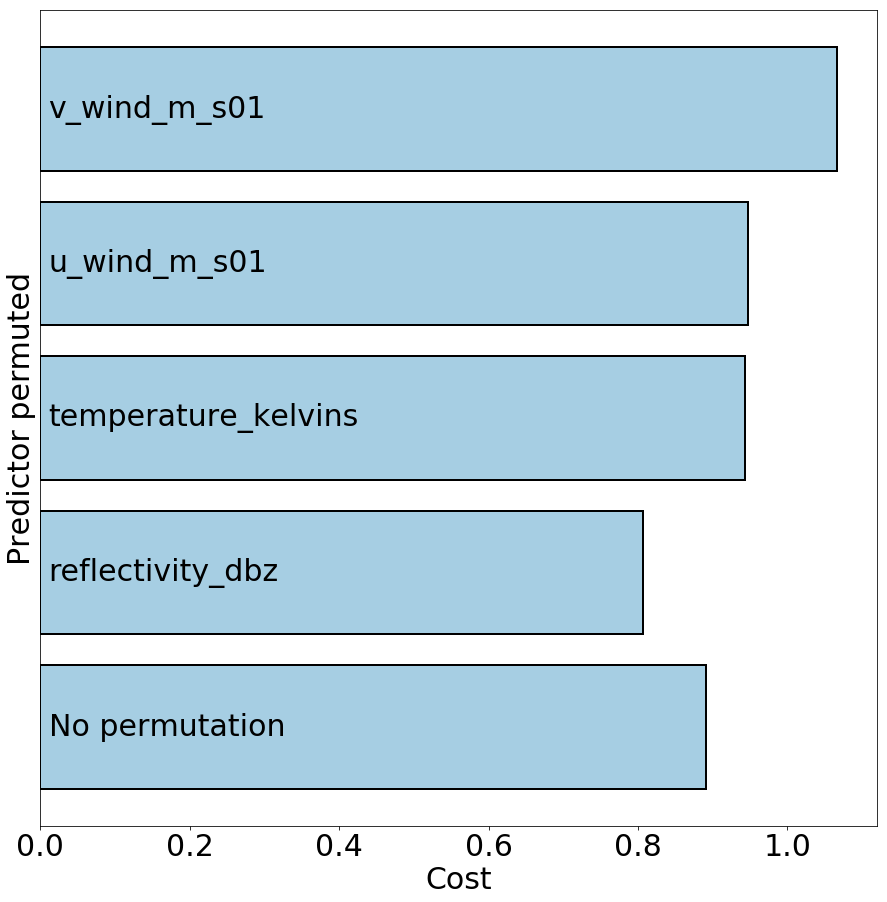

Saving figure to: "/home/ryan.lagerquist/Downloads/ams2019_short_course/permutation_test/breiman_results.jpg"...


In [31]:
breiman_file_name = '{0:s}/breiman_results.jpg'.format(permutation_dir_name)
plot_breiman_results(
    result_dict=permutation_dict, output_file_name=breiman_file_name,
    plot_percent_increase=False)

Plot results of Lakshmanan (multi-pass) version of permutation test.  Again, the most (least) important predictor is at the top (bottom).  The "cost" for predictor x is the cross-entropy when predictor x and all those above it are permuted.

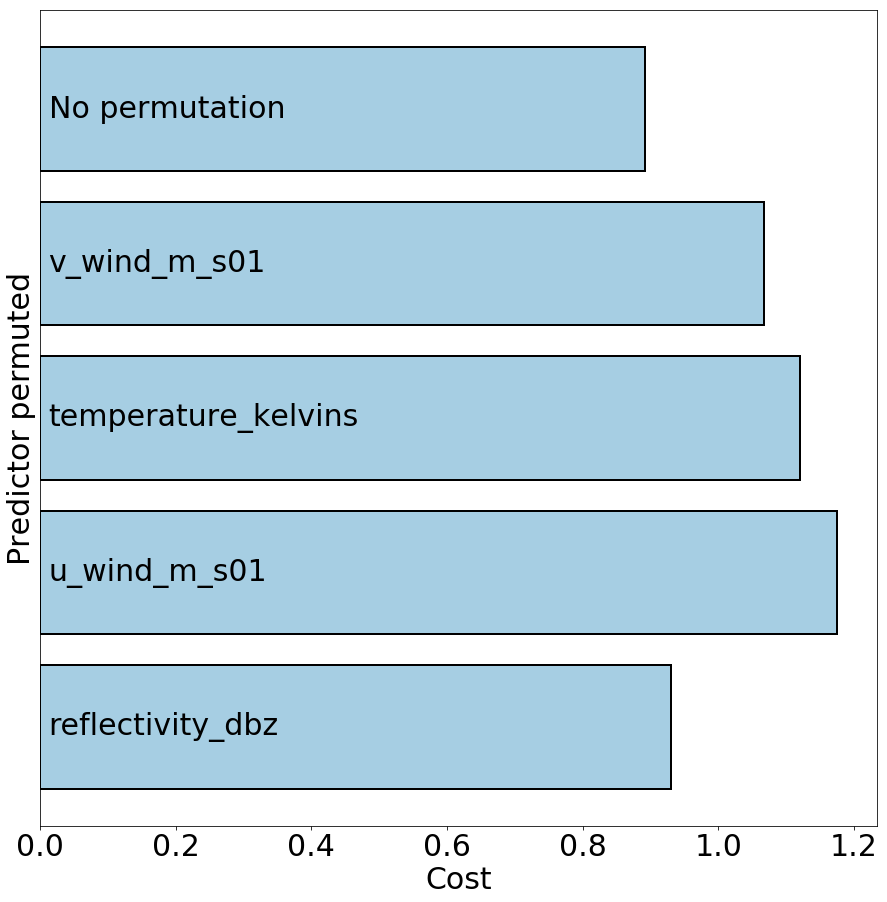

Saving figure to: "/home/ryan.lagerquist/Downloads/ams2019_short_course/permutation_test/lakshmanan_results.jpg"...


In [32]:
lakshmanan_file_name = '{0:s}/lakshmanan_results.jpg'.format(
    permutation_dir_name)
plot_lakshmanan_results(
    result_dict=permutation_dict, output_file_name=lakshmanan_file_name,
    plot_percent_increase=False)